In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

from model import ImageCaptionModel
from decoder import TransformerDecoder, RNNDecoder

2024-05-04 02:00:09.613956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!python preprocessing.py

2024-05-04 02:01:34.066622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Getting training embeddings
2024-05-04 02:02:04.833406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[(240/240)] Processing '../memes900k/images/i-will-find-you-meme.jpg' into 2048-

Getting testing embeddings
[(60/60)] Processing '../memes900k/images/trologirl.jpg' into 2048-D Inception V

Data has been dumped into ../memes900k/data.p!


### Check metadata of the input

In [14]:
## Before this, download the dataset and run preprocessing.py as instructed. 
## This may take like 10 mins, but should only happen once so ok.
## https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 50, axis=0)
img_prep  = lambda x: np.repeat(x, 5, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (12000, 2048)
test_img_feats:   (3000, 2048)

train_images:     (500, 299, 299, 3)
test_images:      (300, 299, 299, 3)


### Running your Transformer model

In [23]:
!python main.py --type transformer --task train --data ../memes900k/data.p --epochs 10 --lr 0.0005 --chkpt_path ../transform_model

python(32711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-05-04 04:10:36.543817: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 04:10:47.318574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Found 400000 word vectors.
Converted 10623 words (905 misses)
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is sim

## Visualization

After training our Transformer model, you can visualize the self-attention layer to examine the behavior of your attention heads and see if any patterns emerge. 

To test out the components of the model interactively, you'll need to deconstruct selections of the model/runner code and get an instance of the model in an interactive context (aka inside the notebook). 



In [24]:
## Feel free to insert auto-reloads as necessary
from main import parse_args, load_model
from decoder import TransformerDecoder, RNNDecoder

## Pull your model into the notebook. This is heavily based off of assignment.py, 
## and feel free to reuse as much as you want. Your final project will probably 
## involve a lot of this investigative reverse-engineering based on what repos 
## you have to stumble upon.
## You're not in a notebook scenario, so use get_default_arguments and feel free to update it...

args = parse_args('--type rnn --task both --data ../memes900k/data.p'.split())

args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)

Model loaded from '../transform_model'


In [25]:
tra_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder (Transf  multiple                 8354528   
 ormerDecoder)                                                   
                                                                 
Total params: 8,354,528
Trainable params: 8,354,528
Non-trainable params: 0
_________________________________________________________________


### Caption Generation

 



There is still one piece of this equation missing. The tokens are sampled from the probabilities your models generate, but your models were required to output logits, not probabilities. This is becasue this assignment, like many NLP models, uses temperature as a parameter in text generation. If the models sampled from  probabilies calculated by simply applying softmax to the logits, then the probability of the most likely word will usually be very high and the models will usually genrate the same, most probable caption every time. We use the temperature as a parameter to even out the probabilites so the model produces more 'creative' captions. This is done by dividing the logits by the temperature parameter before applying softmax. Higher temprature values will give a more creative captiong, while temprature values closer to 0 will be more greedy. Check out [this](https://lukesalamone.github.io/posts/what-is-temperature/) article for a demonstration and further explaination of temprature in NLP models.


In [26]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding.
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input) # expand for adding batch dimension
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    out = []
    for x in caption_so_far:
      word = idsToWords[x]
      if word == "sep":
        word = "<newline>"
      elif word == "emp":
        continue
      out.append(word)
    return ' '.join(out[1:-1])
    # return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])

## generate captions on training set

C1: tells long rambling story about the adventures of another bros dick sep avatar is gay bro
C2: wants to change the song sep every seconds
C3: has four powerpoints too study sep still browsing
C4: dude drake like sep two handles
C5: buys <unk> hat sep immediately folds brim
TRA: guess who <newline>


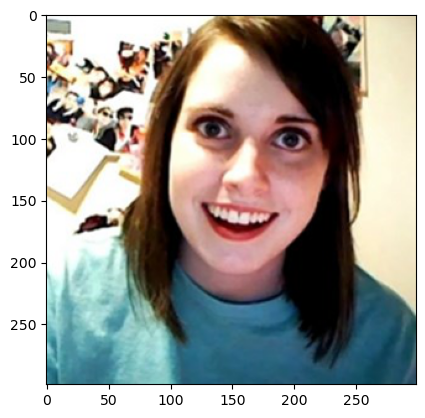

C1: <unk> sep you have no power here
C2: laura the spoiler sep you have no power here
C3: foolish law student sep you have no power here
C4: alcohol sep you have no power here
C5: silly diane sep you thought you would come back to quiet office and work
TRA: hey girl <newline> you re gonna have to do it


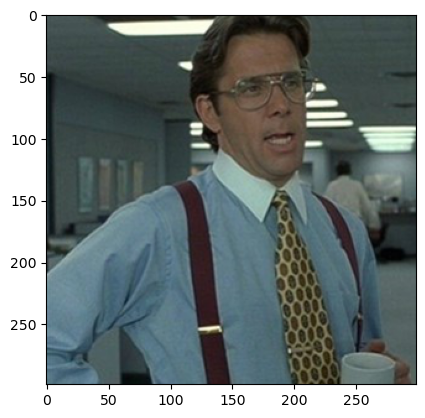

C1: this is the pm ba room sep you have no power here
C2: thomas the grey sep you have no power here
C3: your name is hahn sep you have no power here
C4: no motorcycle sep you have no power here
C5: your kisses have no power here sep ve got oline
TRA: hey girl <newline> you re gonna have bad time


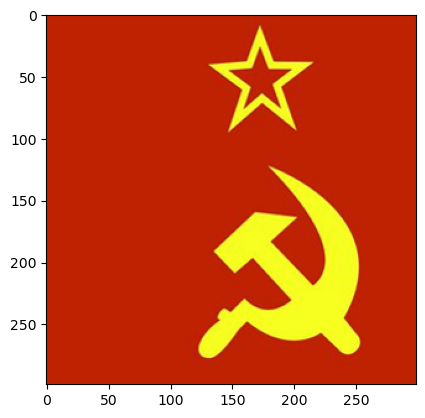

C1: posts inside joke as status sep gets annoyed when you respond
C2: omg im such metalhead sep likes nickelback
C3: checks in at home sep checks back in when she comes back from the store
C4: made photography page on fb sep such photographer just because got canon
C5: omg my kitty died sep post and regret on facebook
TRA: hey girl <newline> but will be so got that


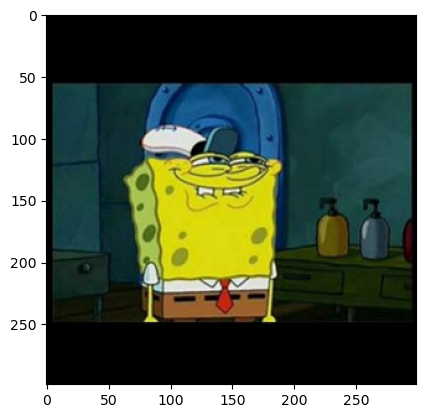

C1: happy birthday alison sep stay classy you smelly pirate hooker
C2: happy birthday chas sep you stay classy
C3: hmmmmm he looks good sep hey everybody come see how good niall looks
C4: thank you nani sep you pirate hooker
C5: stay classy sep simon
TRA: you know what you re going to you <newline> you


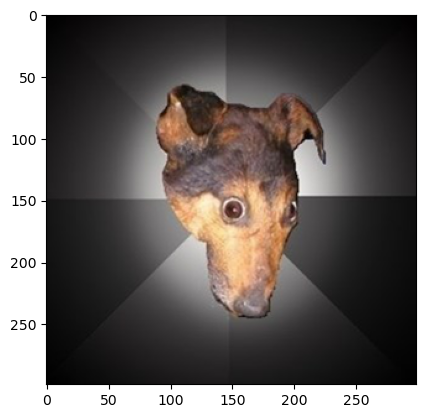

C1: what if adam had sep <unk> the term apple
C2: what if <unk> was real sep and we could date other tumblrs
C3: what if hot problems double take is made by rebecca black sep to make her songs look intelligent
C4: what if those keep hoping about zombie apocalypse sep necrophiliacs
C5: what if the government invented dinosaurs sep to try and prevent time travel
TRA: you have to nicki minaj <newline> it


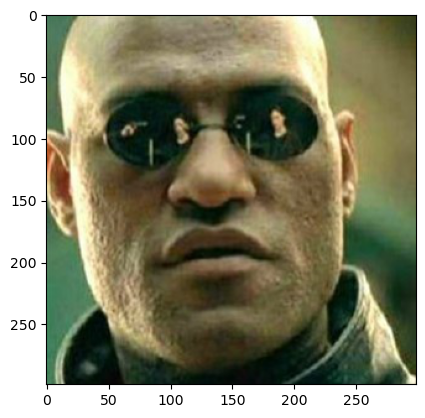

C1: spotted an enemy artillery sep aaand its gone
C2: ve got olympics fever sep aaaaaand it gone
C3: have faith sep aaaand its gone
C4: tell girl how you fell sep <unk> she gone
C5: <unk> riding up that ramp sep aaaaaaand he gone
TRA: you know what mean <newline> you


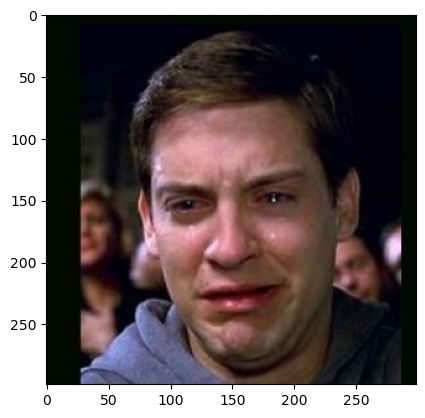

C1: none of my thoughts are my own sep god is controlling them
C2: what if the solar <unk> is an atom sep and planets are the electrons around the nucleus
C3: you havent seen the kony vid sep dear god
C4: what if all girls could be pretty sep but they re to lazy to show it
C5: what if the big bang sep was another universe exploding
TRA: you know what <newline> it


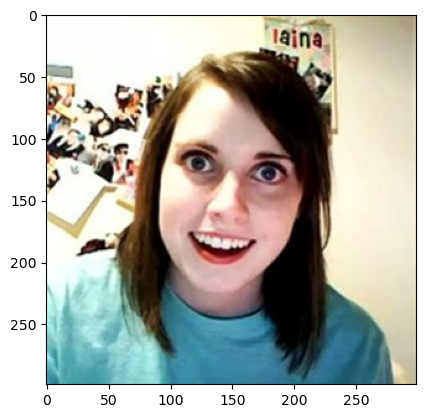

C1: brian birthday sep it kind of big deal
C2: born today sep you stay classy maria <unk>
C3: at main sep dammit wo typed question mark on the teleprompter
C4: loan production sep you stay classy
C5: have many leather bound books sep and my apartment smells of rich mahogany
TRA: you know what you re going to you <newline> you


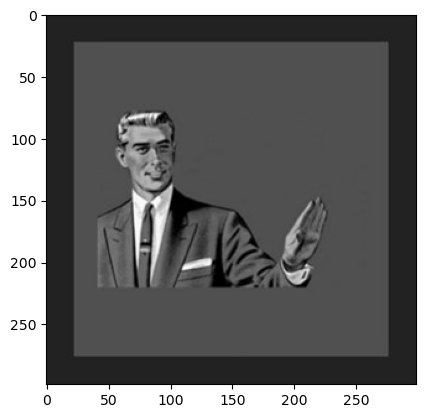

C1: but saying thank you sep can mean something else willy wonka wtf bro conspiracy
C2: what if this whole bill ward situation sep is just massive publicity stunt
C3: what if the <unk> doughboy got fat sep and turned into the michelin man
C4: what if this meme was made by sep the goverment
C5: what if ghosts are alive sep and we re the dead ones
TRA: you know what you re going to be like <newline> it


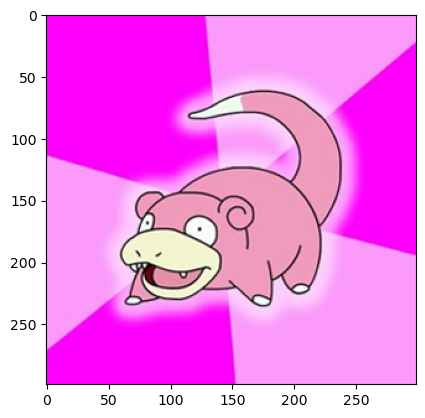

In [28]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 300, 5))), 10, replace=False)
for i in indices:
    curr_image_feat = test_img_feats[i]
    curr_image      = test_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in train_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

## generate captions on test set

In [9]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 3000, 50))), 10, replace=False)
tra_captions = []
for i in indices:
    curr_image_feat = test_img_feats[i]
    tra_caption = gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)
    tra_captions.append(tra_caption)
    #plt.imshow(curr_image)
    #plt.show()
    unfiltered_text, s1 = tra_imcap.get_unfiltered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    filtered_text, s2 = tra_imcap.get_filtered_captions(curr_image_feat, word2idx, word2idx['<pad>'], args.window_size)
    print("unfiltered:", unfiltered_text, s1)
    print("filtered", filtered_text, s2)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: hey girl <newline> 0.1534
filtered hey girl <newline> 0.1534


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: if you could just <newline> 0.0805
filtered <newline> 0.1625


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: not sure if you re going to make sure if you <newline> or just really tired 0.1213
filtered not sure if you re going to make sure if you <newline> or just really tired 0.1213


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: the fuck <newline> 0.1932
filtered the fuck <newline> 0.1932


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: you want to be <newline> no one 0.082
filtered you can be <newline> no one day 0.0824


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: <newline> so can be great 0.0772
filtered <newline> 0.1625


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: you know what you know what you know what you know what you mean to be <newline> 0.0498
filtered you know what you mean <newline> 0.0765


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: you know what do you <newline> it 0.0992
filtered you know what do you <newline> it 0.0992


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: and then said <newline> and will be 0.0935
filtered and then said <newline> and will be 0.0935


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


unfiltered: what if told you <newline> you don think it 0.1288
filtered what if told you <newline> you don think it 0.1288


In [ ]:
from filter_utils import print_captions_and_label
print_captions_and_label(tra_captions, "offensive")